In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import torch.hub 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
models = [torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=False), torchvision.models.mobilenet_v3_small(), torchvision.models.resnet18()]
for model in models: 
    if type(model).__name__ == 'MobileNetV3':
        model.fc = nn.Linear(model.classifier[0].in_features, 11)
    else:
        model.fc == nn.Linear(model.fc.in_features,11)
        

Using cache found in C:\Users\nisha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\users\nisha\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\nisha\appdata\local\programs\python\python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
dataset = datasets.ImageFolder(r"C:\COMP6721\ASL_to_Text_Classification\Sign Language for Numbers", transform=preprocess)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [12]:
batch_size = 64
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
optimizers =[Adam(model.parameters(), lr=0.001) for model in models]
criterion = nn.CrossEntropyLoss()

In [14]:
accuracy = {}
losses = {}
for i,model in enumerate(models):
    model_name = type(model).__name__ 
    print("Model : " , model_name )
    
    optimizer = optimizers[i]
    model.to(device)

    num_epochs = 10
    total_steps = len(train_dataloader)

    t1 = time.time()

    for epoch in range(num_epochs):
        for i, data in enumerate(train_dataloader):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            if (i + 1) % 50 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                        (correct / total) * 100))
                if model_name in accuracy.keys():
                    accuracy[model_name].append((correct / total) * 100)
                else:
                    accuracy[model_name] = [(correct / total) * 100]
                if model_name in losses.keys():
                    losses[model_name].append(loss.item())
                else:
                    losses[model_name] = [loss.item()]    
                
    print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
    torch.save(model.state_dict(), 'numbers-'+model_name+'.pth')
    del model


Model :  ShuffleNetV2
Epoch [1/10], Step [50/258], Loss: 0.0902, Accuracy: 98.44%
Epoch [1/10], Step [100/258], Loss: 0.2814, Accuracy: 90.62%
Epoch [1/10], Step [150/258], Loss: 0.0065, Accuracy: 100.00%
Epoch [1/10], Step [200/258], Loss: 0.0269, Accuracy: 98.44%
Epoch [1/10], Step [250/258], Loss: 0.0796, Accuracy: 98.44%
Epoch [2/10], Step [50/258], Loss: 0.0488, Accuracy: 96.88%
Epoch [2/10], Step [100/258], Loss: 0.0436, Accuracy: 98.44%
Epoch [2/10], Step [150/258], Loss: 0.0197, Accuracy: 98.44%
Epoch [2/10], Step [200/258], Loss: 0.0587, Accuracy: 96.88%
Epoch [2/10], Step [250/258], Loss: 0.0878, Accuracy: 96.88%
Epoch [3/10], Step [50/258], Loss: 0.2121, Accuracy: 93.75%
Epoch [3/10], Step [100/258], Loss: 0.0298, Accuracy: 98.44%
Epoch [3/10], Step [150/258], Loss: 0.0039, Accuracy: 100.00%
Epoch [3/10], Step [200/258], Loss: 0.0297, Accuracy: 100.00%
Epoch [3/10], Step [250/258], Loss: 0.0674, Accuracy: 95.31%
Epoch [4/10], Step [50/258], Loss: 0.0134, Accuracy: 100.00%
Ep

Epoch [7/10], Step [100/258], Loss: 0.0148, Accuracy: 100.00%
Epoch [7/10], Step [150/258], Loss: 0.0040, Accuracy: 100.00%
Epoch [7/10], Step [200/258], Loss: 0.0447, Accuracy: 98.44%
Epoch [7/10], Step [250/258], Loss: 0.0038, Accuracy: 100.00%
Epoch [8/10], Step [50/258], Loss: 0.0009, Accuracy: 100.00%
Epoch [8/10], Step [100/258], Loss: 0.0001, Accuracy: 100.00%
Epoch [8/10], Step [150/258], Loss: 0.0018, Accuracy: 100.00%
Epoch [8/10], Step [200/258], Loss: 0.0019, Accuracy: 100.00%
Epoch [8/10], Step [250/258], Loss: 0.0129, Accuracy: 100.00%
Epoch [9/10], Step [50/258], Loss: 0.0058, Accuracy: 100.00%
Epoch [9/10], Step [100/258], Loss: 0.0003, Accuracy: 100.00%
Epoch [9/10], Step [150/258], Loss: 0.0042, Accuracy: 100.00%
Epoch [9/10], Step [200/258], Loss: 0.0097, Accuracy: 100.00%
Epoch [9/10], Step [250/258], Loss: 0.0048, Accuracy: 100.00%
Epoch [10/10], Step [50/258], Loss: 0.0109, Accuracy: 100.00%
Epoch [10/10], Step [100/258], Loss: 0.0132, Accuracy: 100.00%
Epoch [10/

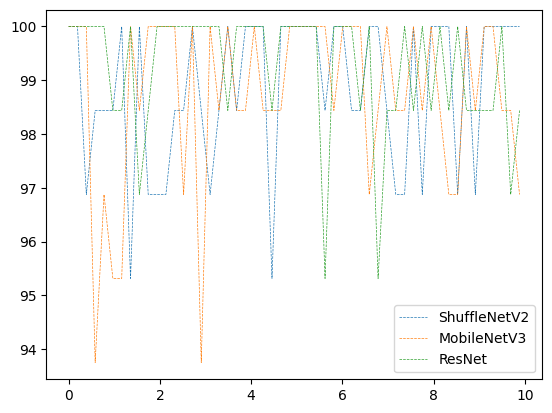

In [35]:
for acc in accuracy.keys():
    model_name = acc
    X = []
    Y = []
    for i, x in enumerate(accuracy[acc]):
        if i % 50 == 0:
            X.append(float(i)/258)
            Y.append(x)
     
    plt.plot(X,Y, label= model_name, linewidth=.5, ls='--' )
    plt.legend(loc='best')


In [37]:
model_paths = ['numbers-ShuffleNetV2.pth','numbers-MobileNetV3.pth','numbers-ResNet.pth']
for i,model in enumerate(models):
    model.load_state_dict(torch.load(model_paths[i]))

TypeError: Expected state_dict to be dict-like, got <class 'torchvision.models.shufflenetv2.ShuffleNetV2'>.

Model :  ShuffleNetV2
Accuracy of the network on the test images: 98 %
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1500
           1       1.00      0.99      0.99      1500
           2       1.00      0.98      0.99      1500
           3       1.00      0.98      0.99      1500
           4       0.99      0.98      0.99      1500
           5       0.99      1.00      1.00      1500
           6       0.99      1.00      0.99      1500
           7       1.00      0.99      0.99      1500
           8       0.99      0.98      0.99      1500
           9       0.99      0.99      0.99      1500
     unknown       0.90      1.00      0.94      1500

    accuracy                           0.99     16500
   macro avg       0.99      0.99      0.99     16500
weighted avg       0.99      0.99      0.99     16500



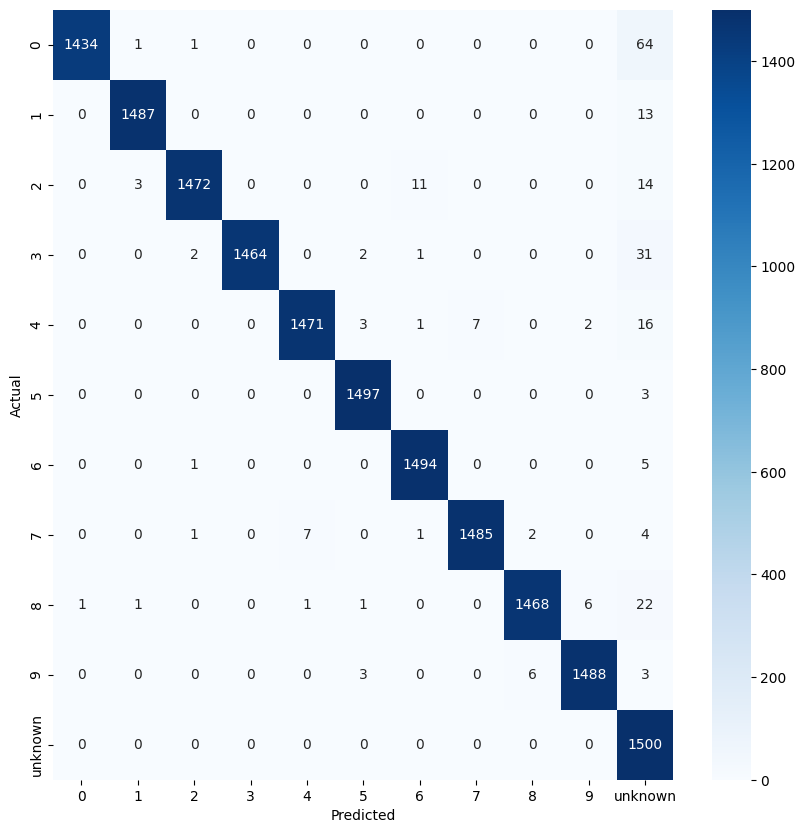

Model :  MobileNetV3
Accuracy of the network on the test images: 99 %
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1500
           1       1.00      0.99      0.99      1500
           2       0.97      1.00      0.98      1500
           3       1.00      0.99      0.99      1500
           4       0.99      1.00      0.99      1500
           5       1.00      0.99      0.99      1500
           6       1.00      0.98      0.99      1500
           7       1.00      1.00      1.00      1500
           8       0.99      1.00      1.00      1500
           9       1.00      1.00      1.00      1500
     unknown       0.99      1.00      0.99      1500

    accuracy                           0.99     16500
   macro avg       0.99      0.99      0.99     16500
weighted avg       0.99      0.99      0.99     16500



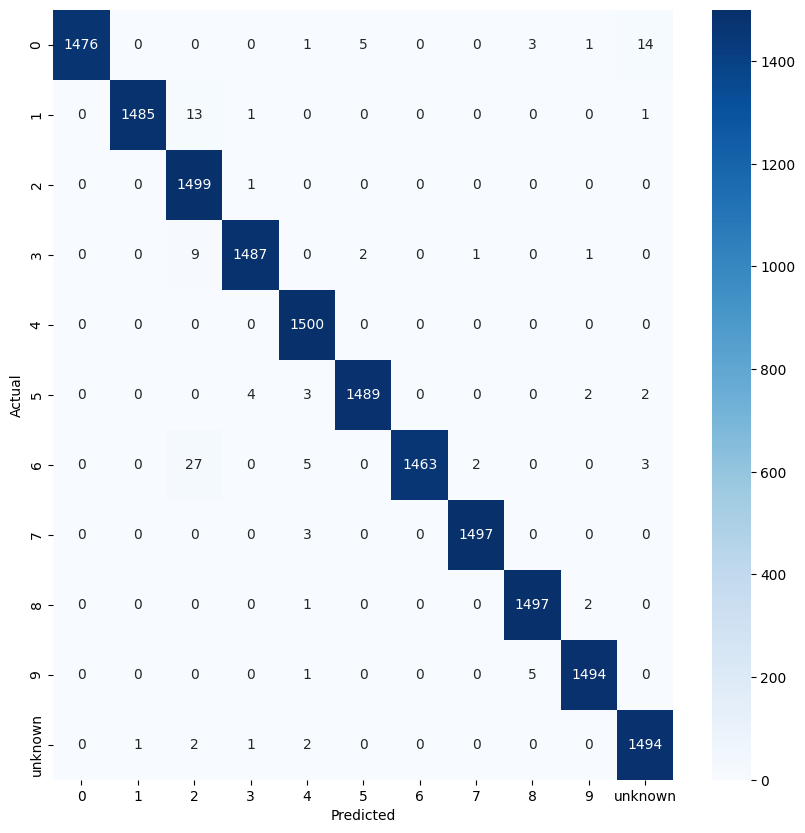

Model :  ResNet
Accuracy of the network on the test images: 99 %
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1500
           1       1.00      1.00      1.00      1500
           2       1.00      1.00      1.00      1500
           3       1.00      1.00      1.00      1500
           4       0.99      1.00      0.99      1500
           5       1.00      1.00      1.00      1500
           6       1.00      1.00      1.00      1500
           7       1.00      0.99      1.00      1500
           8       0.99      1.00      1.00      1500
           9       1.00      1.00      1.00      1500
     unknown       0.99      1.00      1.00      1500

    accuracy                           1.00     16500
   macro avg       1.00      1.00      1.00     16500
weighted avg       1.00      1.00      1.00     16500



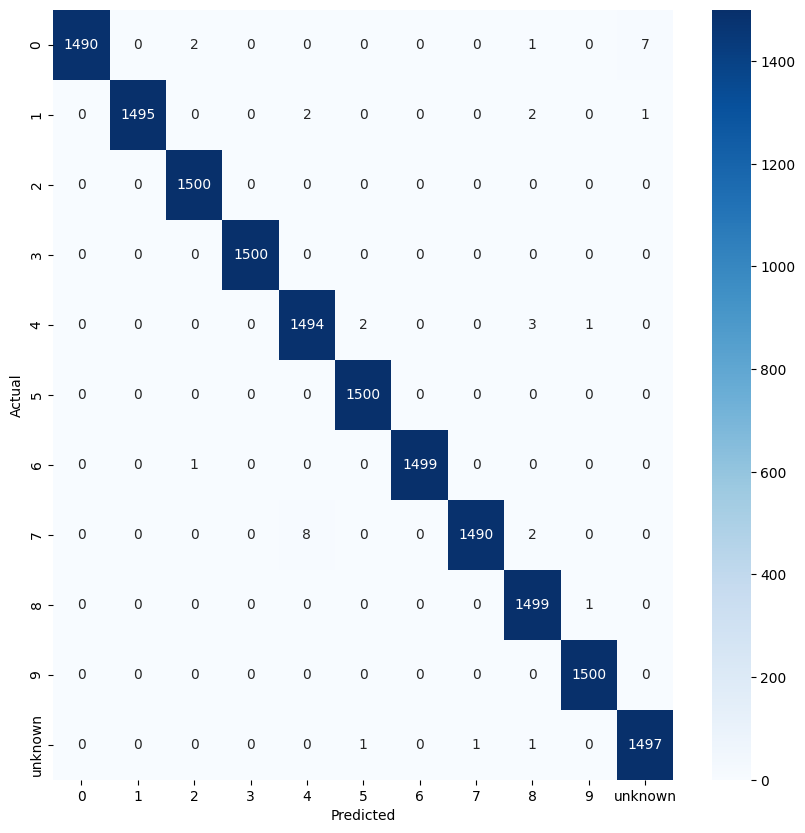

In [38]:
for model in models:
    model.to(device)
    model.eval()
    model_name = type(model).__name__ 
    print("Model : " , model_name )
    test_correct = 0
    test_total = 0
    test_predicted = []
    test_labels = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_predicted += predicted.tolist()
            test_labels += labels.tolist()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * test_correct / test_total))

    target_names = list(train_dataset.dataset.class_to_idx.keys())
    print(classification_report(test_labels, test_predicted, target_names=target_names))

    cm = confusion_matrix(test_labels, test_predicted)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()